In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv
import warnings
warnings.filterwarnings('ignore')
import sys

In [162]:
df_train = pd.read_csv('D:/002. Bismillah Porto bagus/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df_test = pd.read_csv('D:/002. Bismillah Porto bagus/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

In [3]:
df_train.shape

(1460, 80)

In [4]:
df_test.shape

(1459, 79)

In [163]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [164]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Missing Values

<Axes: ylabel='Id'>

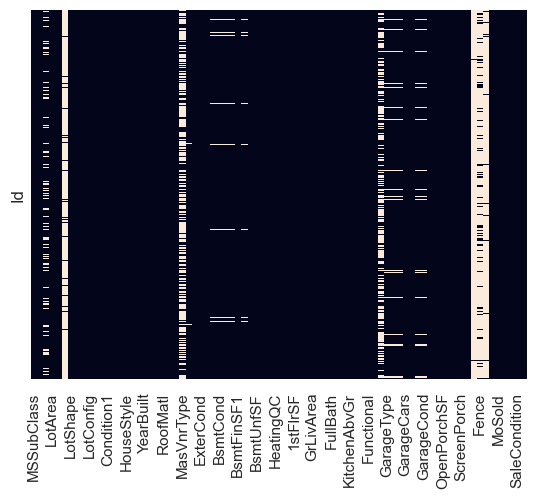

In [168]:
# MISSING VALUES
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False)

<Axes: ylabel='Id'>

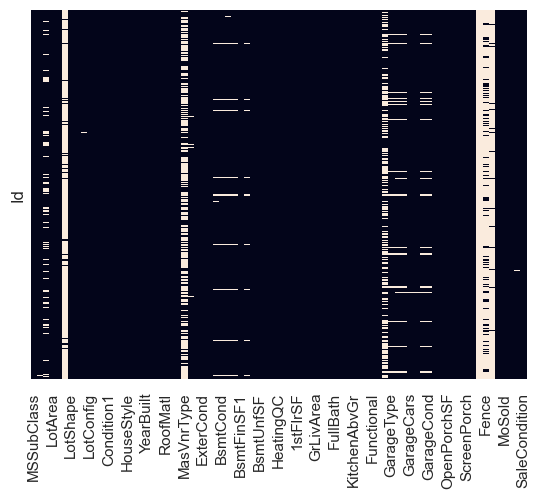

In [169]:
# MISSING VALUES
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False)

In [170]:
col_missing_train = df_train.isnull().sum()
col_missing_train.sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
Length: 80, dtype: int64

In [171]:
col_missing_test = df_train.isnull().sum()
col_missing_test.sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
Length: 80, dtype: int64

In [172]:
df_train = df_train.drop(columns=['PoolQC','MiscFeature','Alley','Fence','MasVnrType', 'FireplaceQu'])

In [173]:
df_test = df_test.drop(columns=['PoolQC','MiscFeature','Alley','Fence','MasVnrType', 'FireplaceQu'])

Continous Features

In [188]:
numerical_cols = [col for col in df_train.columns 
                  if df_train.dtypes[col] != 'object' and col != 'SalePrice']

print(numerical_cols)
print(f'Total Continuous Features: {len(numerical_cols)}')


['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Total Continuous Features: 36


In [189]:
categorical_cols =[col for col in df_train.columns if df_train.dtypes[col]== 'object']
print(categorical_cols)
print(f'Total Categorical Features:', len(categorical_cols))

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Total Categorical Features: 37


In [190]:
year_cols = [feature for feature in numerical_cols if 'Yr' in feature or 'Year' in feature]
print(year_cols)
print(f'Total Year Features:', len(year_cols))

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
Total Year Features: 4


In [191]:
df_train[year_cols].isnull().sum()

YearBuilt        0
YearRemodAdd     0
GarageYrBlt     81
YrSold           0
dtype: int64

Unique Column Values

In [178]:
df_train.apply(lambda x: len(x.unique())).sort_values(ascending=False)

LotArea        1073
GrLivArea       861
BsmtUnfSF       780
1stFlrSF        753
TotalBsmtSF     721
               ... 
HalfBath          3
PavedDrive        3
Street            2
Utilities         2
CentralAir        2
Length: 74, dtype: int64

Kolom Id yang sudah menjadi index merupakan satu satunya kolom dengan nilai unik. Hal ini dibuktikan dengan nilai yang berbeda di tiap barisnya

Kardinalitas dari Kolom Kategorik
Hal ini dilakukan untuk mengetahui encoding yang cocok untuk setiap kolom. Semakin banyak atau beragam kategori, maka membutuhkan encoding yang advanced.

In [179]:
train_cardi = df_train[categorical_cols].apply(lambda x: len(x.unique()))
train_cardi.sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
BsmtFinType2      7
BsmtFinType1      7
Functional        7
GarageType        7
Foundation        6
SaleCondition     6
GarageCond        6
Electrical        6
RoofStyle         6
GarageQual        6
Heating           6
MSZoning          5
ExterCond         5
HeatingQC         5
BsmtExposure      5
BsmtQual          5
BsmtCond          5
BldgType          5
LotConfig         5
LandContour       4
LotShape          4
KitchenQual       4
ExterQual         4
GarageFinish      4
LandSlope         3
PavedDrive        3
Street            2
Utilities         2
CentralAir        2
dtype: int64

In [180]:
test_cardi = df_test[categorical_cols].apply(lambda x: len(x.unique()))
test_cardi.sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      14
SaleType         10
Condition1        9
Functional        8
BsmtFinType2      7
HouseStyle        7
BsmtFinType1      7
GarageType        7
MSZoning          6
GarageCond        6
SaleCondition     6
RoofStyle         6
Foundation        6
KitchenQual       5
BsmtCond          5
HeatingQC         5
GarageQual        5
BsmtQual          5
BldgType          5
ExterCond         5
LotConfig         5
Condition2        5
BsmtExposure      5
GarageFinish      4
RoofMatl          4
LandContour       4
LotShape          4
Electrical        4
Heating           4
ExterQual         4
LandSlope         3
PavedDrive        3
Street            2
Utilities         2
CentralAir        2
dtype: int64

Mengecek Problematik Categorical Columns
Hal ini untuk meninjau apakah terlalu banyak kategori(High Kardinaliti), meninjau kolom dengan banyak missing values, dan Adanya ketidakseimbangan distribusi (imbalance categories)

In [181]:
good_label_cols = [col for col in categorical_cols if set(df_test[col]).issubset(set(df_train[col]))]
print(good_label_cols)
print(f'Total Good Cols:', len(good_label_cols))

['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleCondition']
Total Good Cols: 30


In [182]:
bad_label_cols = list(set(categorical_cols)-set(good_label_cols))
print(bad_label_cols)
print(f'Total Bad Cols:', len(bad_label_cols))

['KitchenQual', 'Exterior1st', 'Utilities', 'MSZoning', 'Functional', 'SaleType', 'Exterior2nd']
Total Bad Cols: 7


Dari 37 Kolom kategorik, diperoleh informasi bahwa ada 7 kolom yang bermasalah. Sehingga kolom kategorik sisanya 30 (good cols). Akan dicari masalah dari ketujuh kolom tsb.

In [183]:
set(df_train['Utilities']), set(df_test['Utilities'])


({'AllPub', 'NoSeWa'}, {'AllPub', nan})

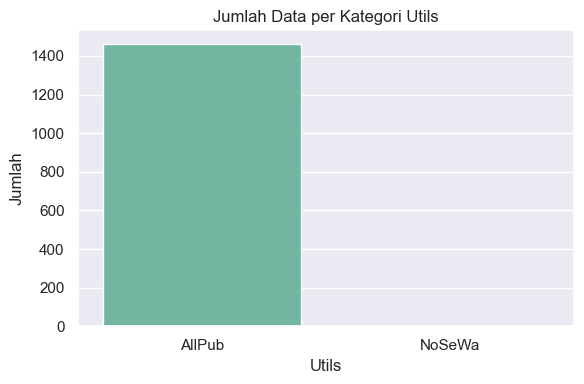

In [184]:
utils = df_train['Utilities'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=utils.index, y=utils.values, palette='Set2')
plt.title('Jumlah Data per Kategori Utils')
plt.xlabel('Utils')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

Pada kategori Utils, adanya imbalance dan kecondongan pada satu kategori saja yaitu Allpub sehingga pada NoSewa 0. Hal ini akan menyebabkan ketimpangan saat melakukan permodelan, dimana model belum belajar jika ada kategori lain selain allpub.

In [108]:
set(df_train['KitchenQual']), set(df_test['KitchenQual'])

({'Ex', 'Fa', 'Gd', 'TA'}, {'Ex', 'Fa', 'Gd', 'TA', nan})

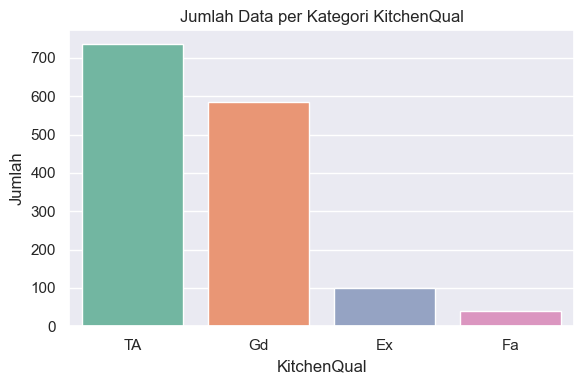

In [109]:
kitchen = df_train['KitchenQual'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=kitchen.index, y=kitchen.values, palette='Set2')
plt.title('Jumlah Data per Kategori KitchenQual')
plt.xlabel('KitchenQual')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

Kategori pada Kitchen Qual terlihat adanya 2 perbedaan kategori dibanding kedua lainnya. Kategori Ex dan Fa memiliki range atau selisih cukup jauh jika dibandingkan dengan TA dan Gd.

In [110]:
set(df_train['Functional']), set(df_test['Functional'])

({'Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ'},
 {'Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ', nan})

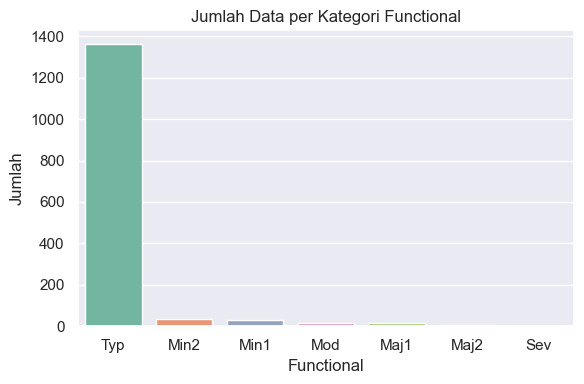

In [111]:
functional = df_train['Functional'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=functional.index, y=functional.values, palette='Set2')
plt.title('Jumlah Data per Kategori Functional')
plt.xlabel('Functional')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

Adanya imbalance kategori Typ dibanding 6 kategori lainnya. Perlu dicek apakah tetap digunakan atau tidak. Karena dengan dominasi Typ akan berpengaruh pelatihan model.

In [112]:
set(df_train['MSZoning']), set(df_test['MSZoning'])

({'C (all)', 'FV', 'RH', 'RL', 'RM'}, {'C (all)', 'FV', 'RH', 'RL', 'RM', nan})

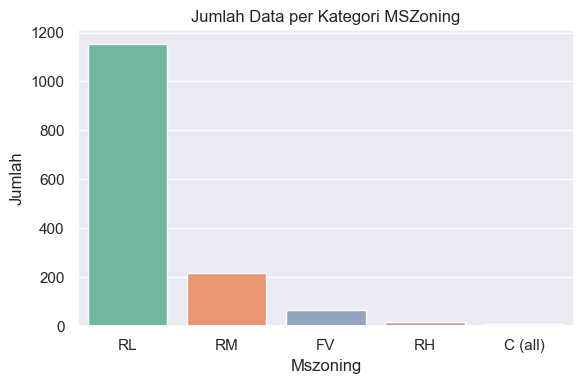

In [113]:
mszoning = df_train['MSZoning'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=mszoning.index, y=mszoning.values, palette='Set2')
plt.title('Jumlah Data per Kategori MSZoning')
plt.xlabel('Mszoning')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [114]:
set(df_train['SaleType']), set(df_test['SaleType'])

({'COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth', 'WD'},
 {'COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth', 'WD', nan})

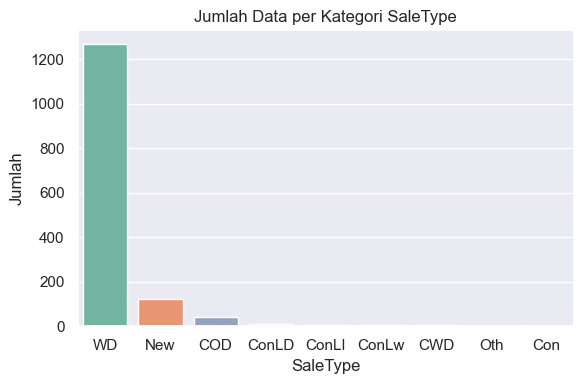

In [115]:
saletype = df_train['SaleType'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=saletype.index, y=saletype.values, palette='Set2')
plt.title('Jumlah Data per Kategori SaleType')
plt.xlabel('SaleType')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [116]:
set(df_train['Exterior1st']), set(df_test['Exterior1st'])

({'AsbShng',
  'AsphShn',
  'BrkComm',
  'BrkFace',
  'CBlock',
  'CemntBd',
  'HdBoard',
  'ImStucc',
  'MetalSd',
  'Plywood',
  'Stone',
  'Stucco',
  'VinylSd',
  'Wd Sdng',
  'WdShing'},
 {'AsbShng',
  'AsphShn',
  'BrkComm',
  'BrkFace',
  'CBlock',
  'CemntBd',
  'HdBoard',
  'MetalSd',
  'Plywood',
  'Stucco',
  'VinylSd',
  'Wd Sdng',
  'WdShing',
  nan})

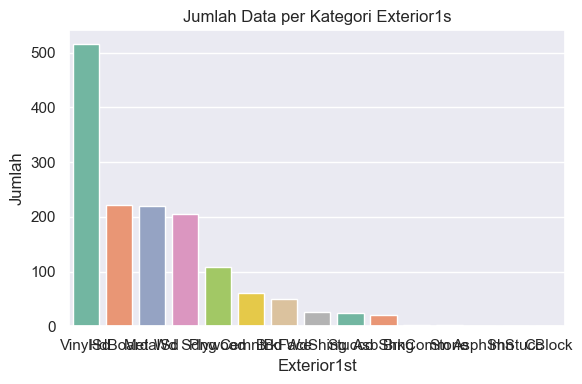

In [117]:
exterior1st = df_train['Exterior1st'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=exterior1st.index, y=exterior1st.values, palette='Set2')
plt.title('Jumlah Data per Kategori Exterior1s')
plt.xlabel('Exterior1st')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [118]:
set(df_train['Exterior2nd']), set(df_test['Exterior2nd'])

({'AsbShng',
  'AsphShn',
  'Brk Cmn',
  'BrkFace',
  'CBlock',
  'CmentBd',
  'HdBoard',
  'ImStucc',
  'MetalSd',
  'Other',
  'Plywood',
  'Stone',
  'Stucco',
  'VinylSd',
  'Wd Sdng',
  'Wd Shng'},
 {'AsbShng',
  'AsphShn',
  'Brk Cmn',
  'BrkFace',
  'CBlock',
  'CmentBd',
  'HdBoard',
  'ImStucc',
  'MetalSd',
  'Plywood',
  'Stone',
  'Stucco',
  'VinylSd',
  'Wd Sdng',
  'Wd Shng',
  nan})

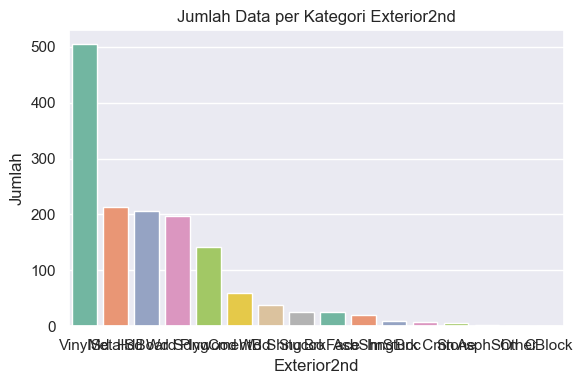

In [119]:
exterior2nd = df_train['Exterior2nd'].fillna('NaN').value_counts()


plt.figure(figsize=(6, 4))
sns.barplot(x=exterior2nd.index, y=exterior2nd.values, palette='Set2')
plt.title('Jumlah Data per Kategori Exterior2nd')
plt.xlabel('Exterior2nd')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [120]:
df_train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


Data Variabel Tahunan (Year_Cols)

In [192]:
year_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [193]:
train_year_cardi = df_train[year_cols].apply(lambda x: len(x.unique()))
train_year_cardi.sort_values(ascending=False)

YearBuilt       112
GarageYrBlt      98
YearRemodAdd     61
YrSold            5
dtype: int64

In [194]:
test_year_cardi = df_test[year_cols].apply(lambda x: len(x.unique()))
test_year_cardi.sort_values(ascending=False)

YearBuilt       106
GarageYrBlt      98
YearRemodAdd     61
YrSold            5
dtype: int64

Fungsi dibawah ini untuk mengetahui lamanya dari tahun dibangun, garasi dibangun dengan tahun terjualnya sebuah rumah kemudian dikorelasikan dengan harga rumah terjual atau saleprice

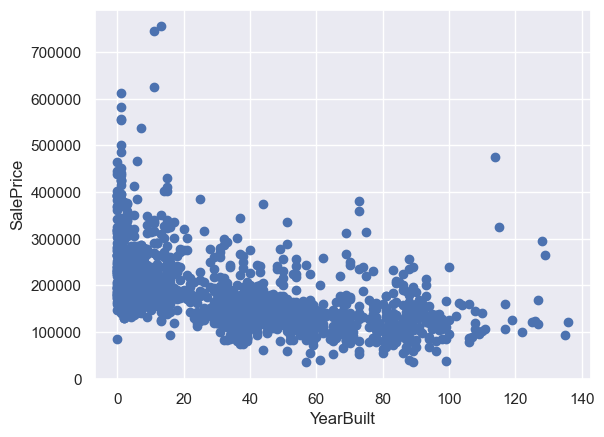

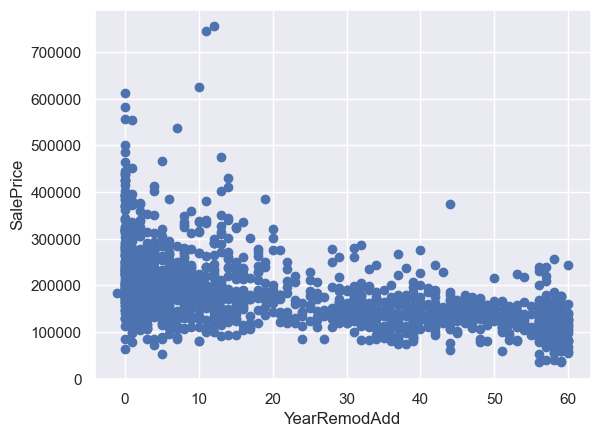

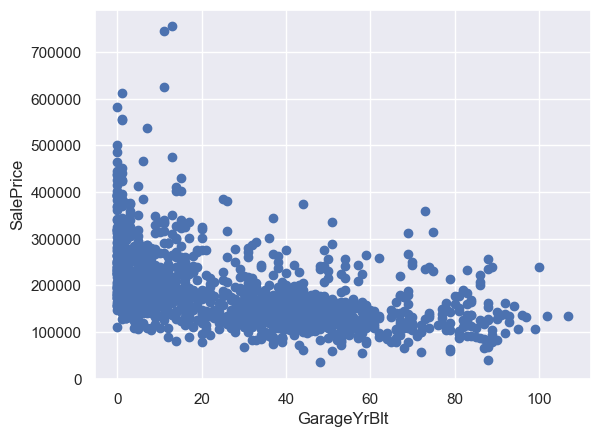

In [195]:
for feature in year_cols:
    if feature!='YrSold':
        data = df_train.copy()
        data[feature]=data['YrSold']-data[feature]

        plt.scatter(data[feature],data['SalePrice'])
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()

In [196]:
discrete_feature = [feature for feature in numerical_cols if len(df_train[feature].unique())<25 and feature not in year_cols]
print("discrete variables count: {}".format(len(discrete_feature)))

discrete variables count: 17


Syntax di bawah ini kita akan melihat apakah kategori dalam fitur diskrit memiliki pengaruh berbeda terhadap harga jual rumah (Sale Price).
Selain itu, untuk menentukan apakah fitur memiliki pola atau tren yang signifikan terhadap target (Sale Price)

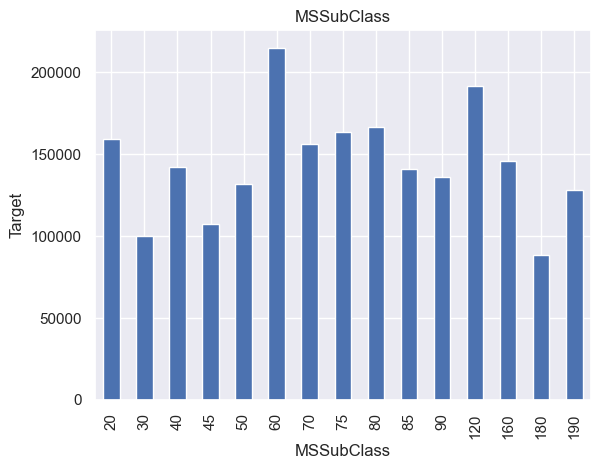

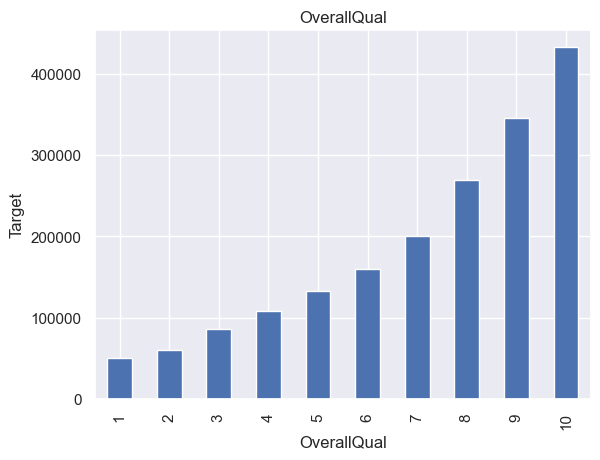

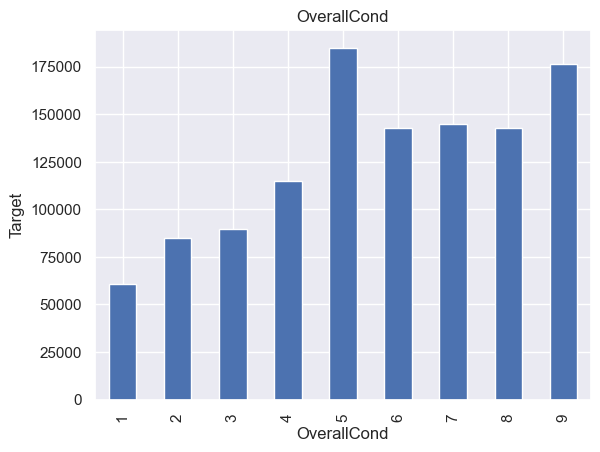

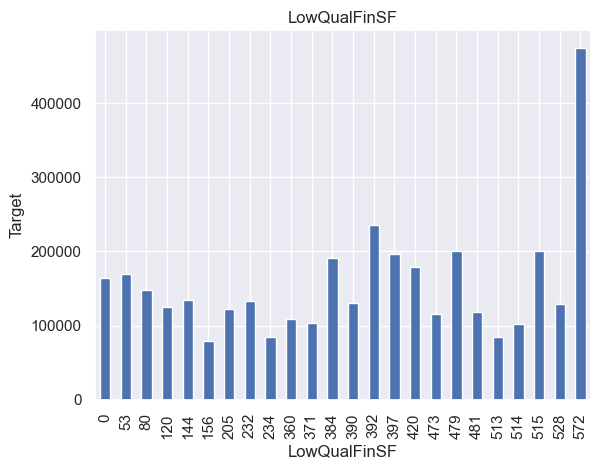

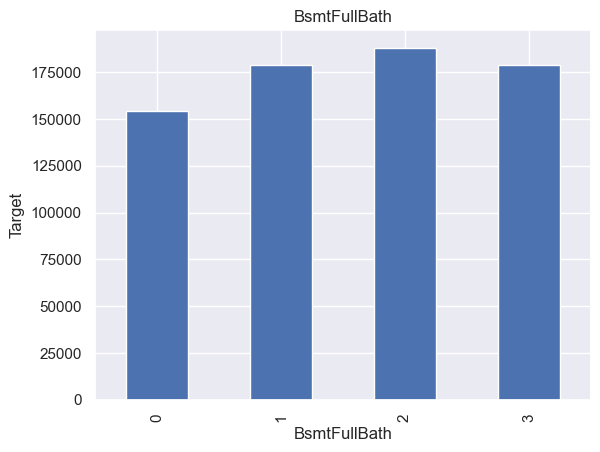

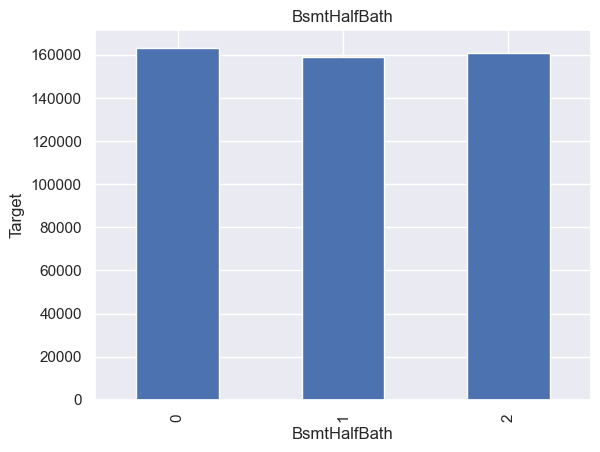

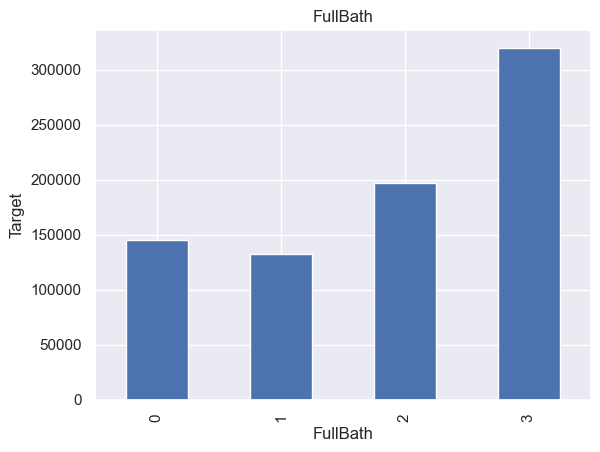

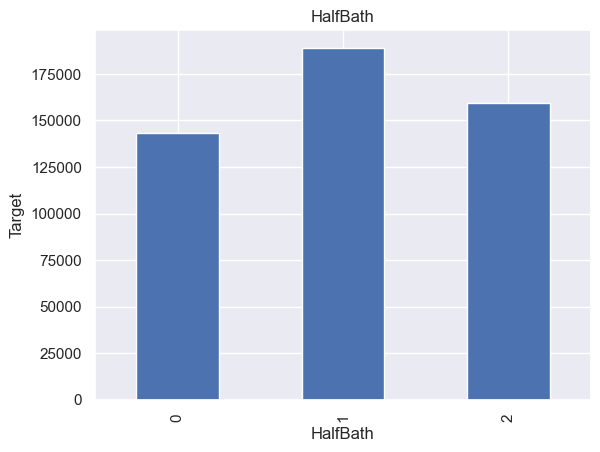

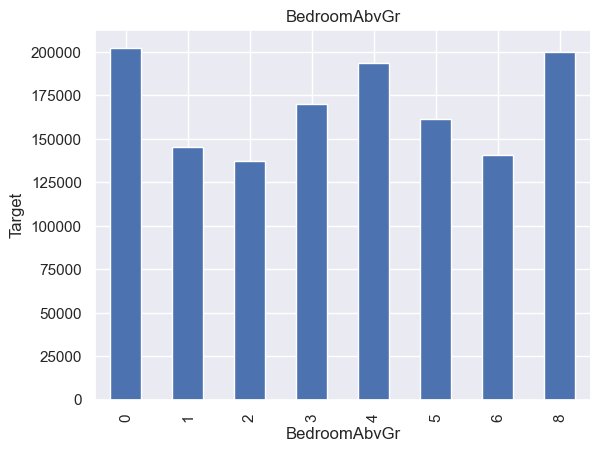

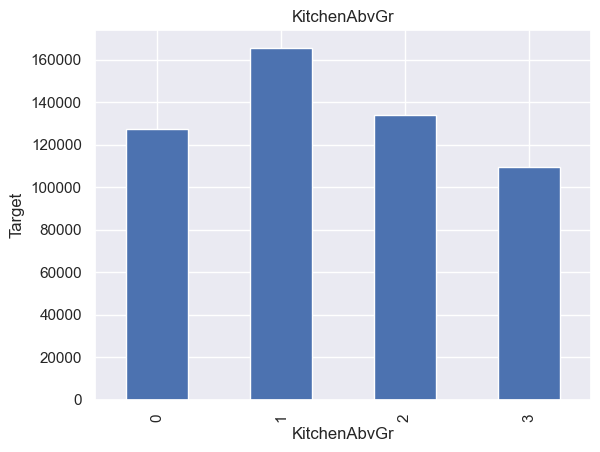

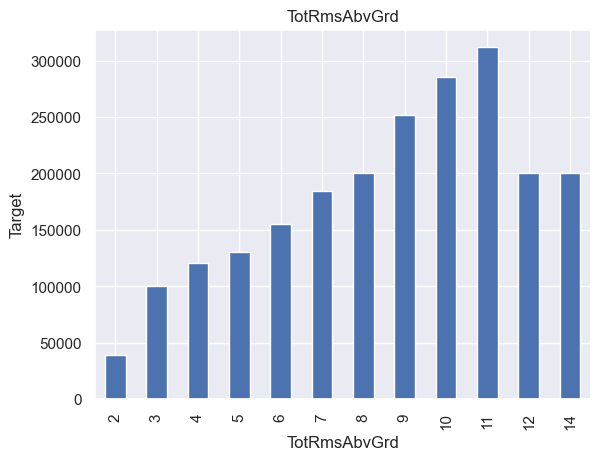

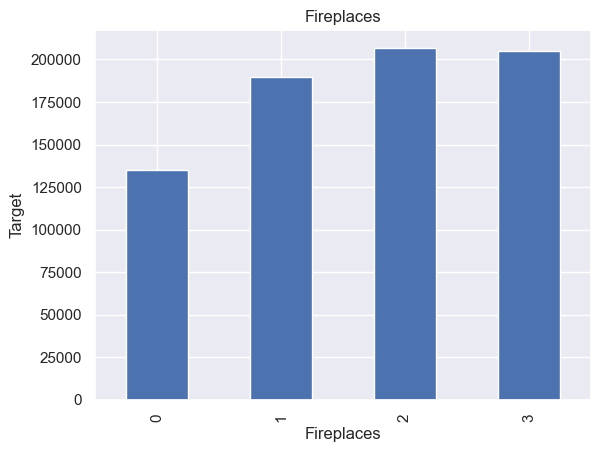

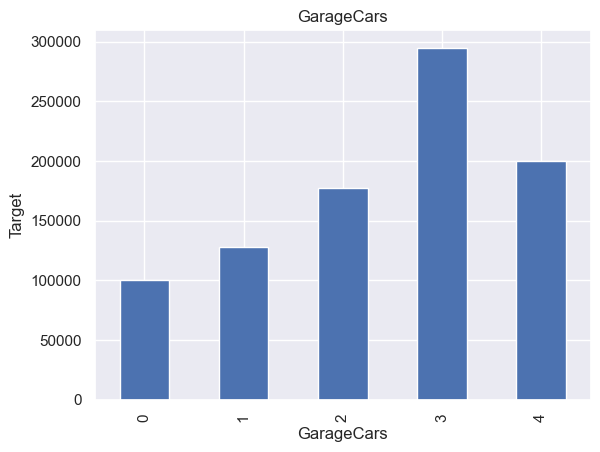

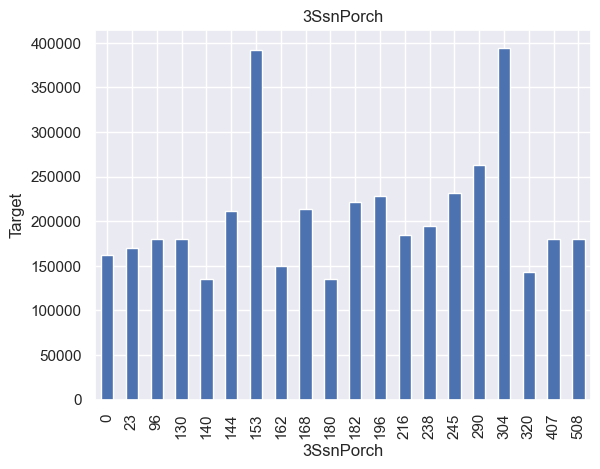

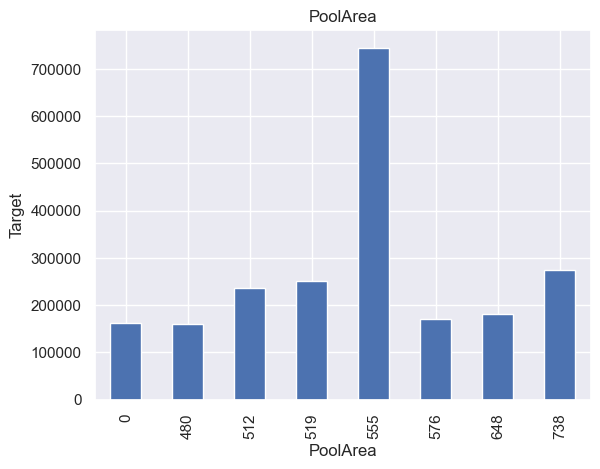

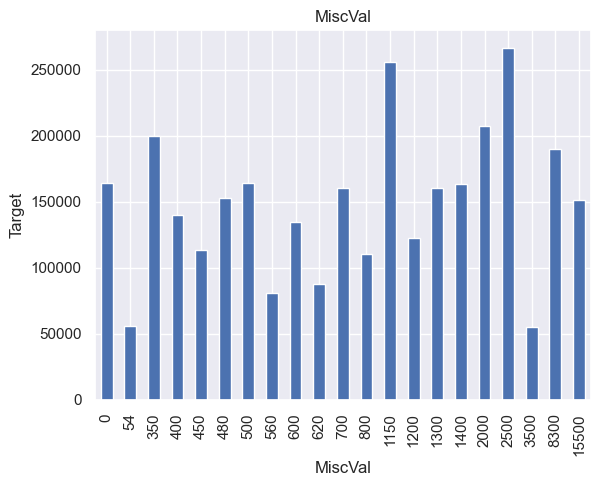

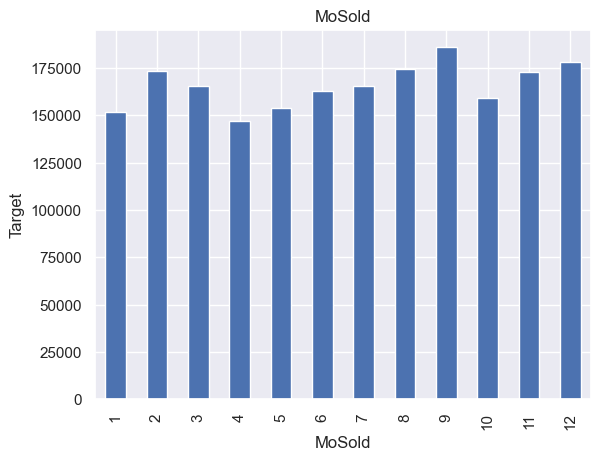

In [197]:
for feature in discrete_feature:
    data=df_train.copy()
    data.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.title(feature)
    plt.show()

Kontinus Features

In [198]:
continous_feature =[feature for feature in numerical_cols if feature not in discrete_feature+year_cols]
print("Continous Feature Count {}".format(len(continous_feature)))

Continous Feature Count 15


Syntax dibawah ini untuk melihat bentuk distribusi dari fitur kontinu, apakah distribusi normal, skewed, atau merata. Serta melihat outlier atau rentang nilai terlalu lebar

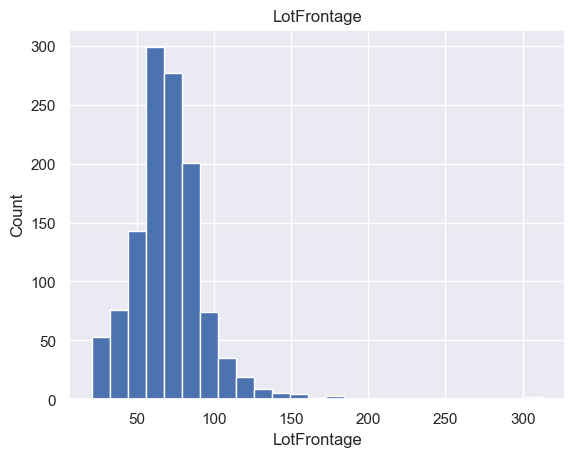

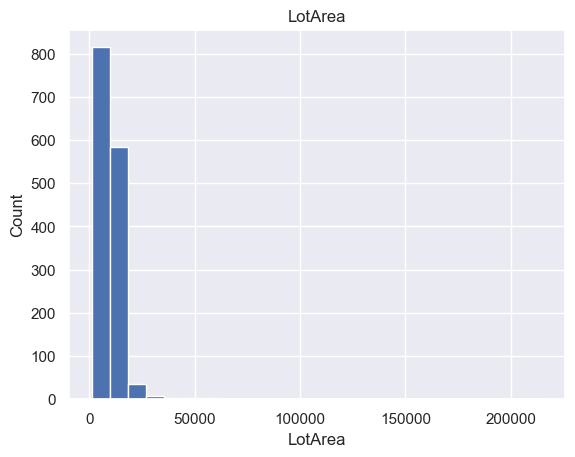

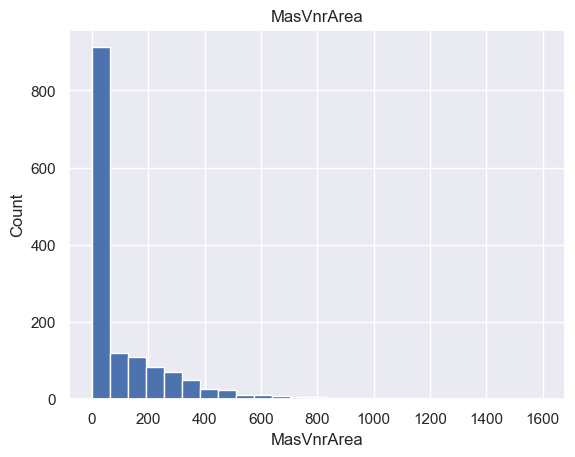

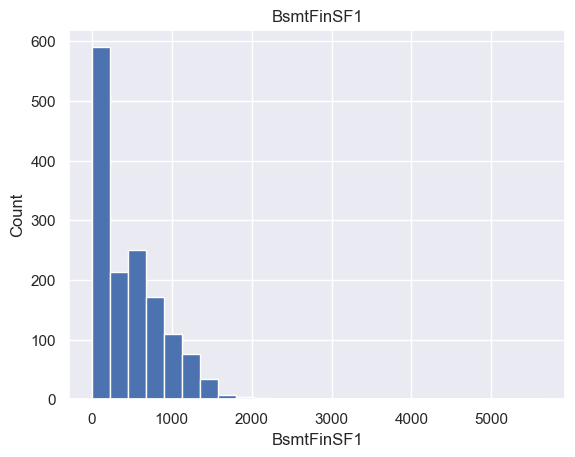

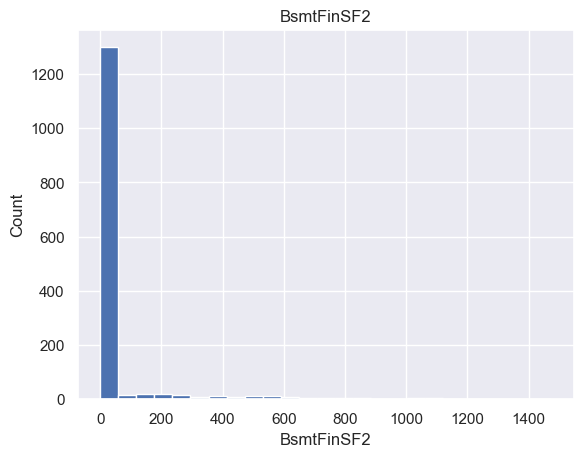

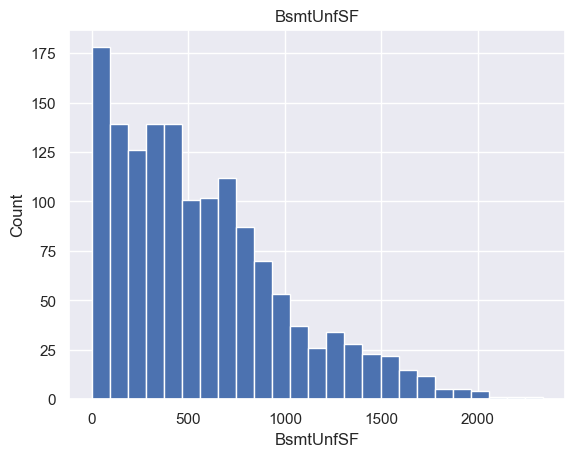

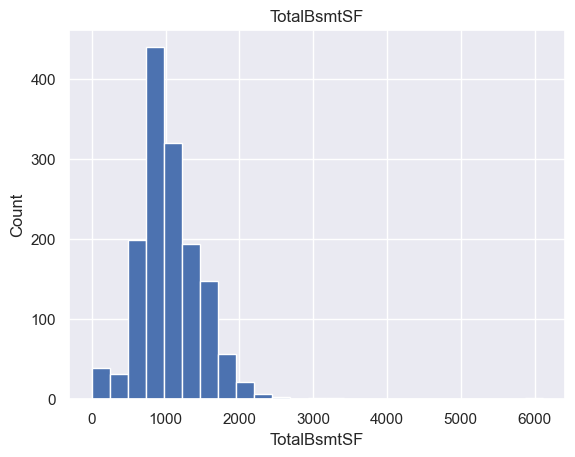

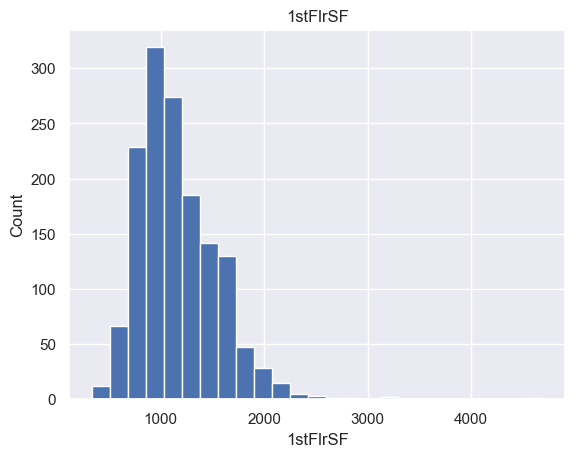

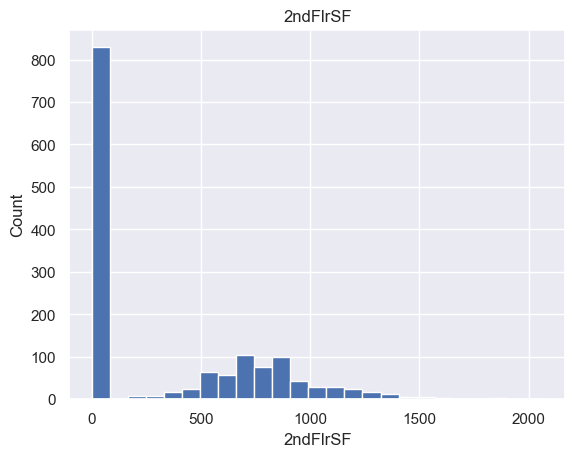

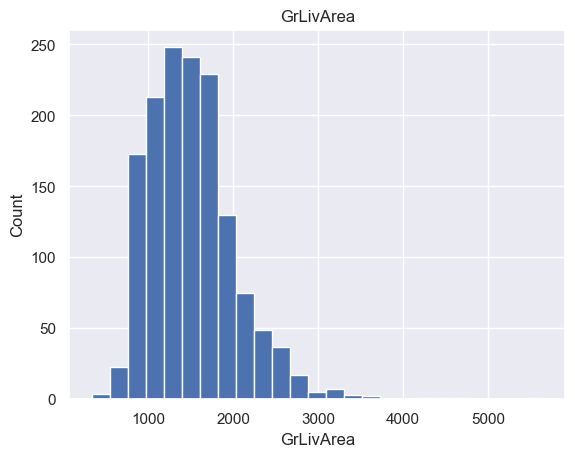

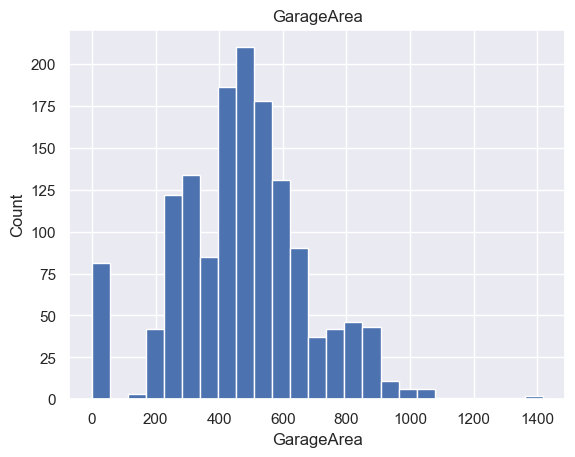

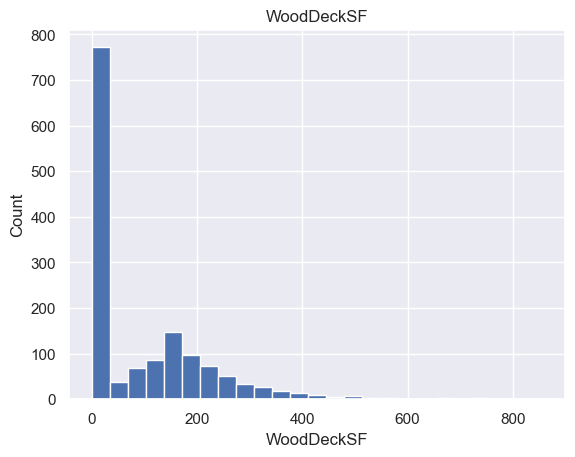

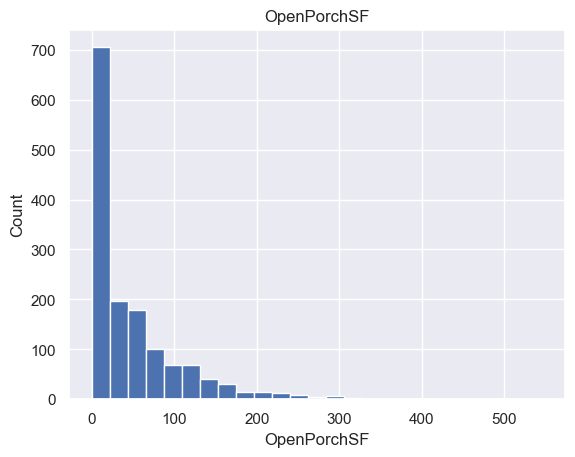

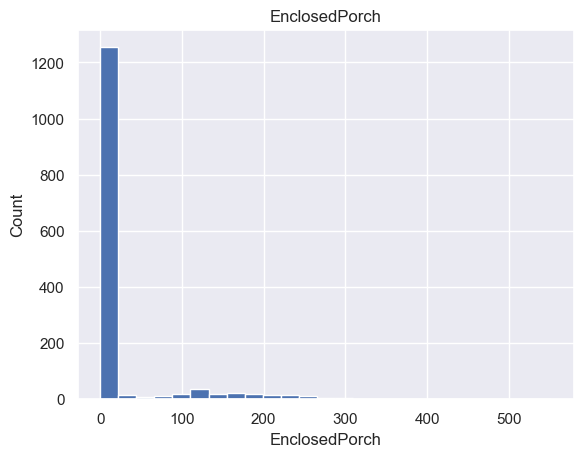

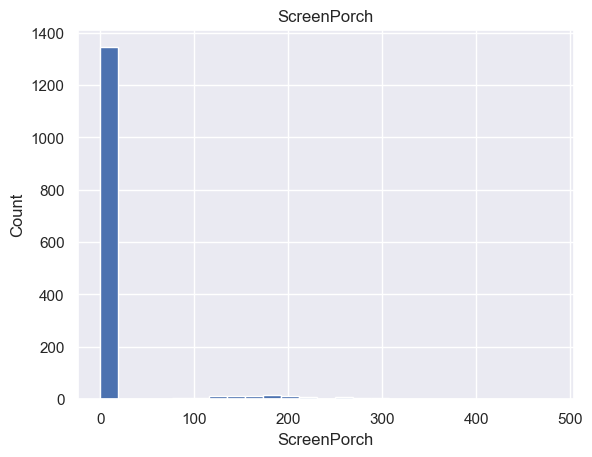

In [199]:
for feature in continous_feature:
    data = df_train.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

Data Dependen (Sale Price)

Text(0.5, 1.0, 'Distribusi Sale Price')

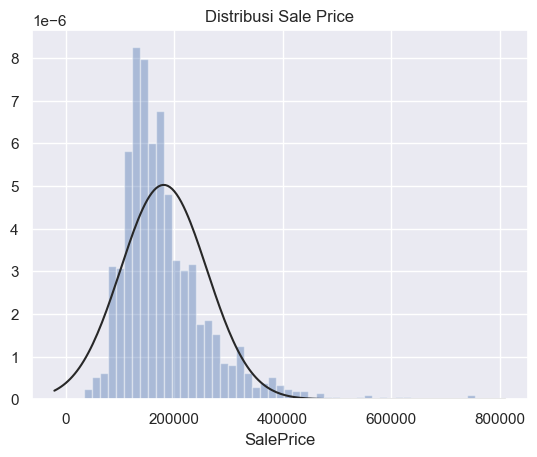

In [200]:
import scipy.stats as st
sns.distplot(df_train['SalePrice'], kde = False, fit=st.norm)
plt.title('Distribusi Sale Price')

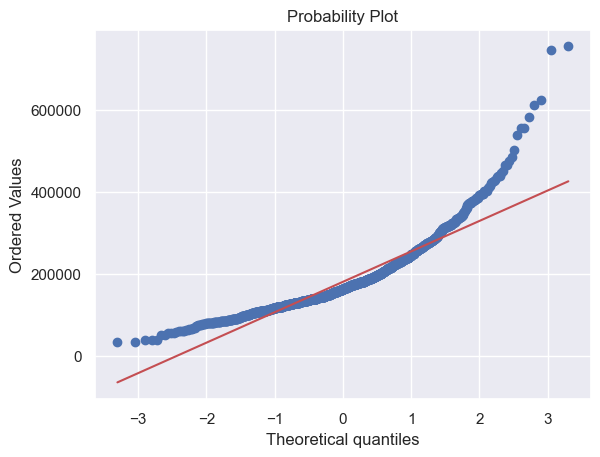

In [201]:
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [202]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [132]:
from scipy import stats

stat, p = stats.shapiro(df_train['SalePrice'].dropna())

print(f'p-value = {p:.4f}')
if p < 0.01:
    print("Distribusi **tidak normal** (p < 0.01)")
else:
    print("Distribusi **normal** (p >= 0.01)")


p-value = 0.0000
Distribusi **tidak normal** (p < 0.01)


In [100]:
from scipy import stats
from scipy.stats import zscore

# Normalisasi data terlebih dahulu (optional tapi umum dilakukan untuk K-S test terhadap distribusi normal)
z = zscore(df_train['SalePrice'].dropna())

# Uji Kolmogorov-Smirnov terhadap distribusi normal
stat, p = stats.kstest(z, 'norm')

print(f'p-value = {p:.4f}')
if p < 0.01:
    print("Distribusi **tidak normal** (p < 0.01)")
else:
    print("Distribusi **normal** (p >= 0.01)")


p-value = 0.0000
Distribusi **tidak normal** (p < 0.01)


Cek Normalitas Features

In [133]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(df_train[numerical_cols])
normal = normal.apply(test_normality)
print(not normal.any())

False


Artinya, tidak ada features numerik yang berdistribusi normal

Checking Korelasi

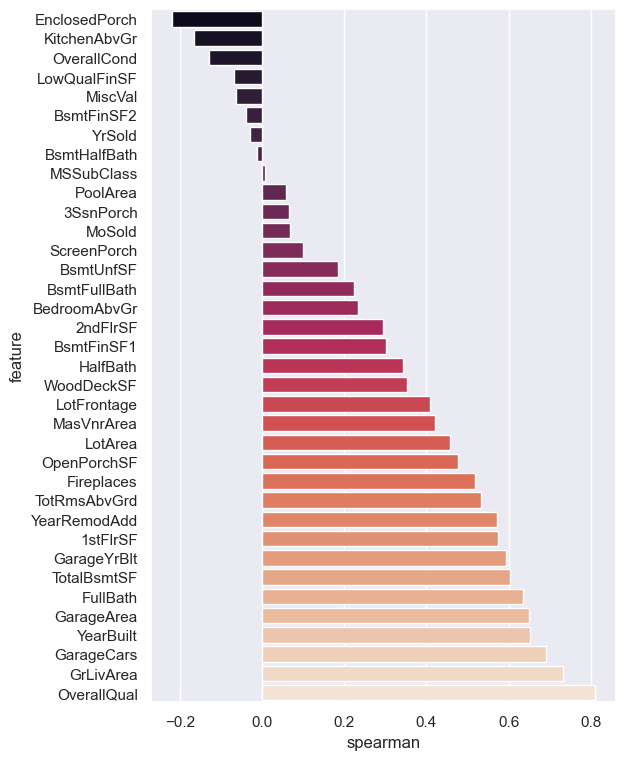

In [203]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h',palette = "rocket")

spearman(df_train, numerical_cols)

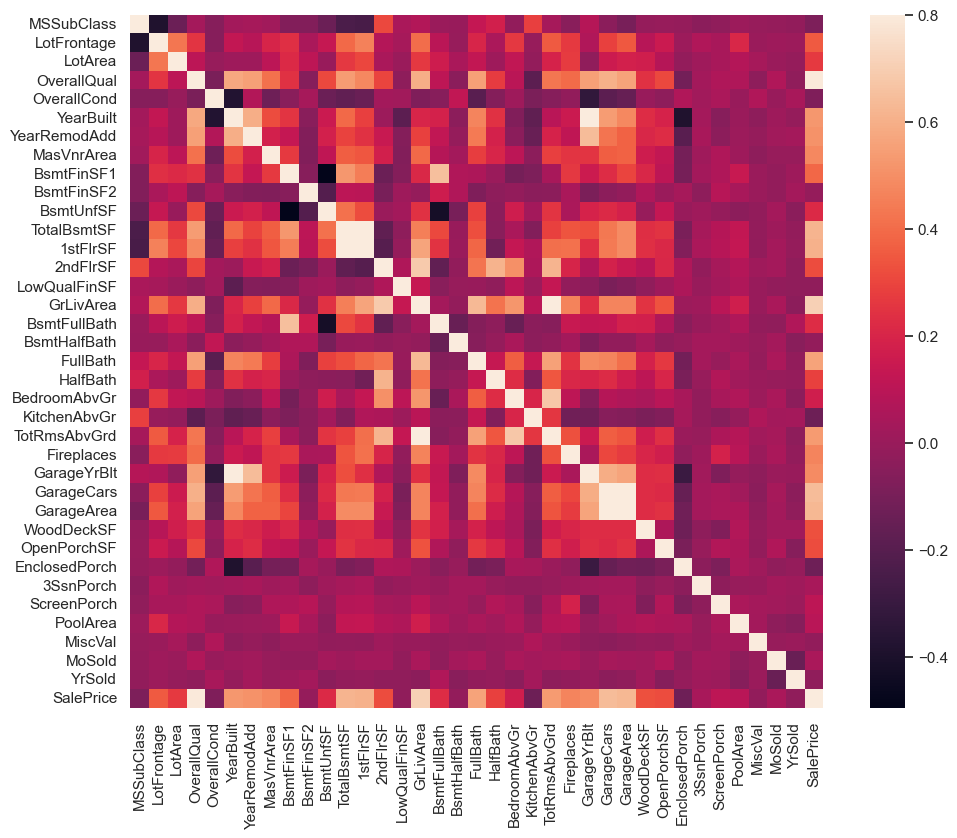

In [204]:
corrmat = df_train[numerical_cols+['SalePrice']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [205]:
correlation = df_train.select_dtypes(include=['number']).corr()
print(correlation['SalePrice'].sort_values(ascending=False), '\n')

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64 



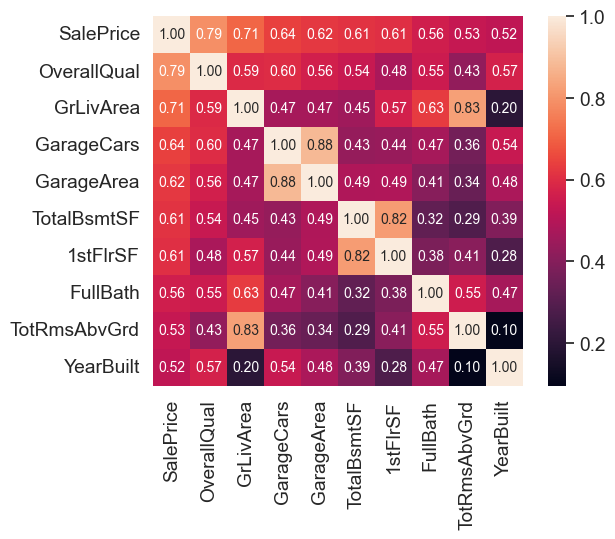

In [206]:
corrmat = df_train.select_dtypes(include=['number']).corr()

k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].dropna().values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

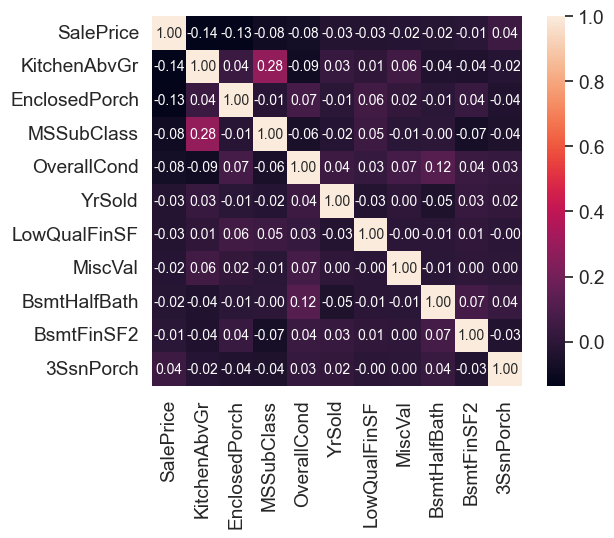

In [207]:
k = 10 
cols = corrmat.nsmallest(10, 'SalePrice')['SalePrice'].index
cols = cols.insert(0,'SalePrice')
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

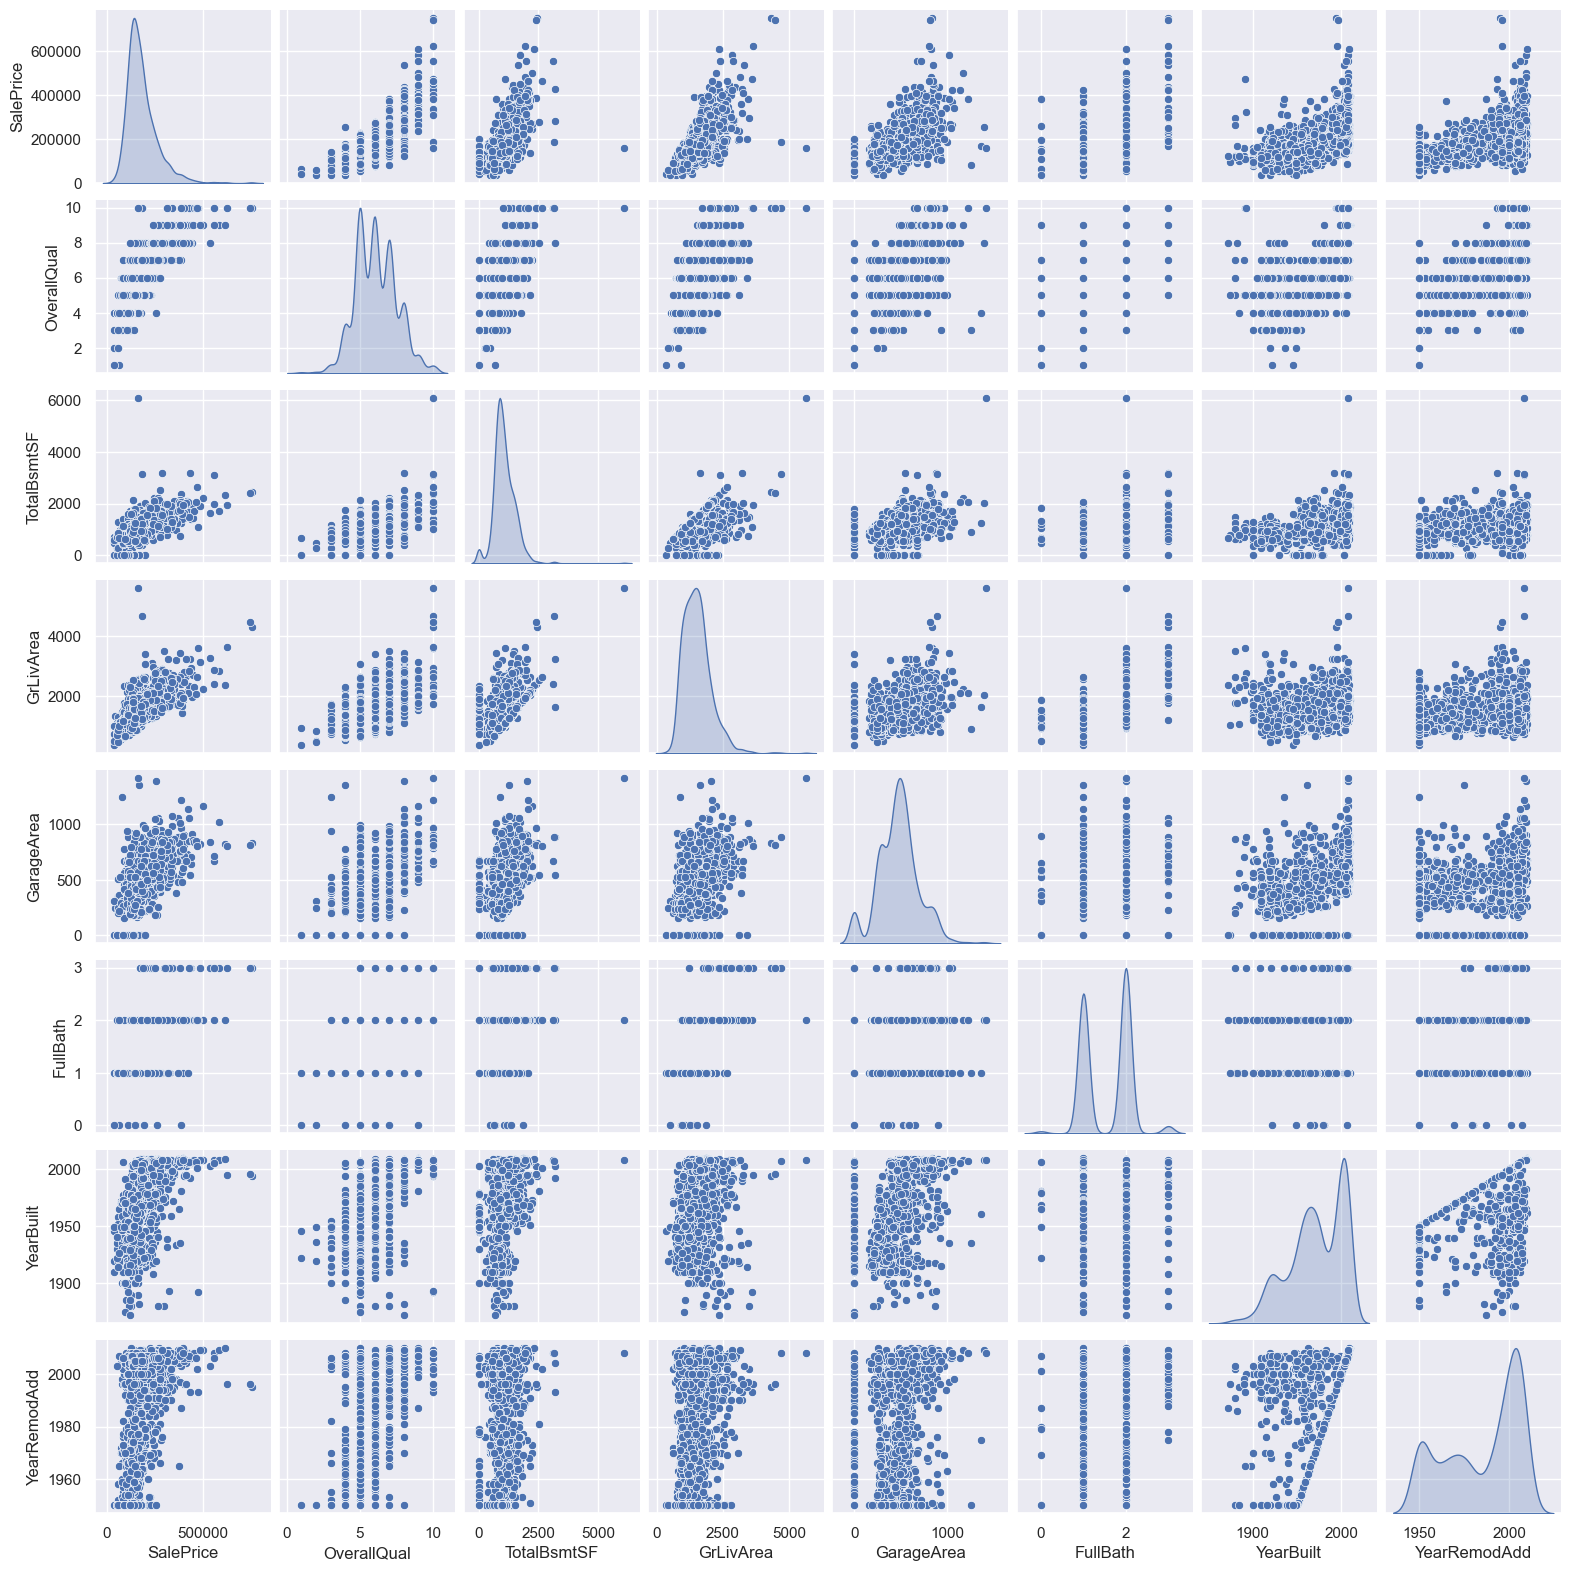

In [208]:
sns.set()
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(df_train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

Imputasi untuk Missing values pada Data Kategorik

In [209]:
categorical_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [210]:
def replace_null_with_mode(df, categorical_cols):
    for column in categorical_cols:
        if df[column].isnull().any():
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value,inplace=True)
    return df


In [211]:
df_train= replace_null_with_mode(df_train,categorical_cols)

In [212]:
df_test= replace_null_with_mode(df_test,categorical_cols)

In [213]:
df_train.isnull().sum().sort_values(ascending=False)

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
LotArea            0
MSZoning           0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 74, dtype: int64

Imputasi Untuk Data Numerik
Dalam data numerik terbagi menjadi dua, Diskrit dan Kontinu

In [214]:
discrete_feature = [feature for feature in numerical_cols if len(df_train[feature].unique())<25 and feature not in year_cols]
print("discrete variables count: {}".format(len(discrete_feature)))

discrete variables count: 17


In [215]:
#untuk diskrit akan diisi dengan modus

def replace_null_discrete(df, discrete_feature):
    for col in discrete_feature:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
    return df

In [216]:
df_train = replace_null_discrete(df_train, discrete_feature)

In [217]:
df_test = replace_null_discrete(df_test, discrete_feature)

In [218]:
continous_feature =[feature for feature in numerical_cols if feature not in discrete_feature+year_cols]
print("Continous Feature Count {}".format(len(continous_feature)))

Continous Feature Count 15


In [220]:
#untuk kontinu akan diisi dengan median

def replace_null_continuous(df, continuous_cols, round_median=False):
    for col in continuous_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            if round_median:
                median_val = round(median_val)
            df[col].fillna(median_val, inplace=True)
    return df


In [221]:
df_train=replace_null_continuous(df_train,continous_feature)

In [222]:
df_test=replace_null_continuous(df_test,continous_feature)

In [223]:
df_train.isnull().sum().sort_values(ascending=False)

GarageYrBlt      81
MSSubClass        0
LotFrontage       0
LotArea           0
Street            0
                 ..
MoSold            0
YrSold            0
SaleType          0
SaleCondition     0
SalePrice         0
Length: 74, dtype: int64

In [224]:
year_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [225]:
#untuk tahun akan diisi dengan modus

def replace_null_year(df, year_cols):
    for col in year_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
    return df

In [226]:
df_train=replace_null_year(df_train, year_cols)

In [227]:
df_test=replace_null_year(df_test, year_cols)

In [229]:
df_train.to_csv('df_train.csv', index=True)
df_test.to_csv('df_test.csv', index=True)